# Exercise 3
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU.

**Make sure you use the best practices you learned in class**.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Convolutional Neural Network - Classifiying CIFAR-10 (40 points)

So far we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very messy for large complex networks.

Thankfully, we can use **automatic differentiation** to automate the computation of backward passes in neural networks. The autograd package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your network will define a computational graph. Nodes in the graph will be Tensors,
and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

If we want to compute gradients with respect to some Tensor, then we set `requires_grad=True` when constructing that Tensor. Any PyTorch operations on that Tensor will cause a computational graph to be constructed, allowing us to later perform backpropagation through the graph. If `x` is a Tensor with `requires_grad=True`, then after backpropagation `x.grad` will be another Tensor holding the gradient of `x`.

Sometimes you may wish to prevent PyTorch from building computational graphs when performing certain operations on Tensors with `requires_grad=True`; for example, we usually don't want to backpropagate through the weight update steps when evaluating a neural network. In such scenarios we can use the `torch.no_grad()` context manager to prevent the construction of a computational graph.

In this exercise, you will accomplish the following:
1. Train a convolutional network using PyTorch.
2. Evaluate your model using a confusion matrix.
3. Solve the localization task using regression.

### Data Preprocessing

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_len = int(0.7 * len(trainset))  # 70% for training
val_len = len(trainset) - train_len    # 30% for validation
train_subset, val_subset = random_split(trainset, [train_len, val_len]) # Create the random split
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Image shape:  torch.Size([3, 32, 32])
      bird        cat        cat       ship


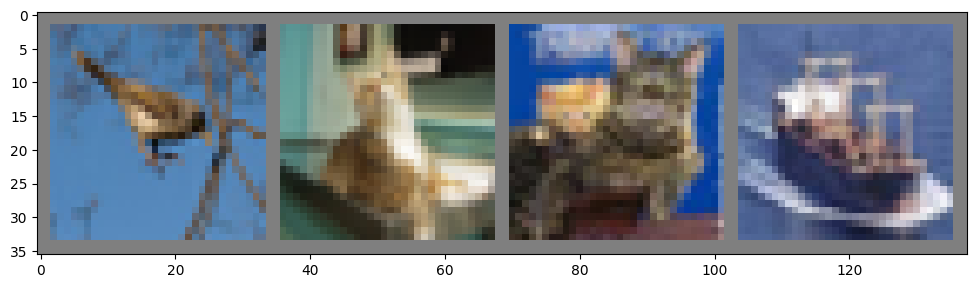

In [ ]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

### Construct a CNN in PyTorch

In the following class, initiate your different layers in the `__init__` method and define your architecture in the `forward` method. Make sure the `forward` method has a single return value.

1. Make good use of the documentation and experiment will different layers, activations and architectures, batch sizes, regularization, filter sizes, dimensions, number of layers and whatever you learned in class.
2. Use your intuition from the previous exercises and additional sources such as the stackoverflow, Medium, etc. - **do not try to perform a massive grid search.**
3. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
4. It is not allowed to use famous models that have been already implemented by PyTorch (resnet, densenet, alexnet, etc).
5. Make sure your code runs reasonably fast (no more than 15 minutes on CPU).
6. Use the best architecture you find and train it for 1-10 epochs.
7. Visualize the loss and accuracy of your network during training. You can use matplotlib.
8. You should get above 60% accuracy on the test set.
**(20 points)**

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Initiate the different layers you wish to use in your network.            #
        # This method has no return value.                                          #
        #############################################################################

        # Convolutional Layer: Takes in 3 input channels (RGB), returns 32 feature maps, uses 3x3 kernel with padding
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)

        # Convolutional Layer: Takes in 32 input channels, returns 64 feature maps, uses 3x3 kernel with padding
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)

        # Convolutional Layer: Takes in 64 input channels, returns 128 feature maps, uses 3x3 kernel with padding
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        # Pooling Layer: Uses 2x2 max pooling for downsampling
        self.pool = nn.MaxPool2d(2, 2)

        # Dropout Layer for regularization: Probability of dropout is set to 0.25
        self.dropout = nn.Dropout(0.25)

        # Batch Normalization Layer: Applies Batch Normalization to the input with 32 channels
        self.batch_norm1 = nn.BatchNorm2d(32)

        # Batch Normalization Layer: Applies Batch Normalization to the input with 64 channels
        self.batch_norm2 = nn.BatchNorm2d(64)

        # Batch Normalization Layer: Applies Batch Normalization to the input with 128 channels
        self.batch_norm3 = nn.BatchNorm2d(128)

        # Fully Connected Layer: Takes in flattened 128*4*4 input, returns 512 outputs
        self.fc1 = nn.Linear(128 * 4 * 4, 512)

        # Fully Connected Layer: Takes in 512 inputs, returns 10 outputs
        self.fc2 = nn.Linear(512, 10)

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def forward(self, x):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and obtain class predictions.                                     #
        # This function returns the predication of your model.                      #
        #############################################################################

        x = self.pool(F.relu(self.batch_norm1(self.conv1(x)))) # Apply ReLU activation after conv1 and batch normalization
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x)))) # Apply ReLU activation after conv2 and batch normalization
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x)))) # Apply ReLU activation after conv3 and batch normalization
        x = x = torch.flatten(x, start_dim=1) # Flatten all dimensions except batch
        x = self.dropout(x) # Apply dropout
        x = F.relu(self.fc1(x)) # Apply ReLU activation after fc1
        x = self.dropout(x) # Apply dropout
        x = self.fc2(x) # Output layer

        return x

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

net = Net()
criterion = None
optimizer = None
#############################################################################
# TO DO:                                                                    #
# Define the loss function and optimizer.                                   #
#############################################################################

# Define CrossEntropyLoss as the criterion for classification
criterion = nn.CrossEntropyLoss()

# Adam optimizer
# Parameters:
  # - net.parameters(): Specifies the parameters (weights and biases) to be optimized
# Hyperparameters:
  # - lr: Learning rate controls the step size during optimization
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


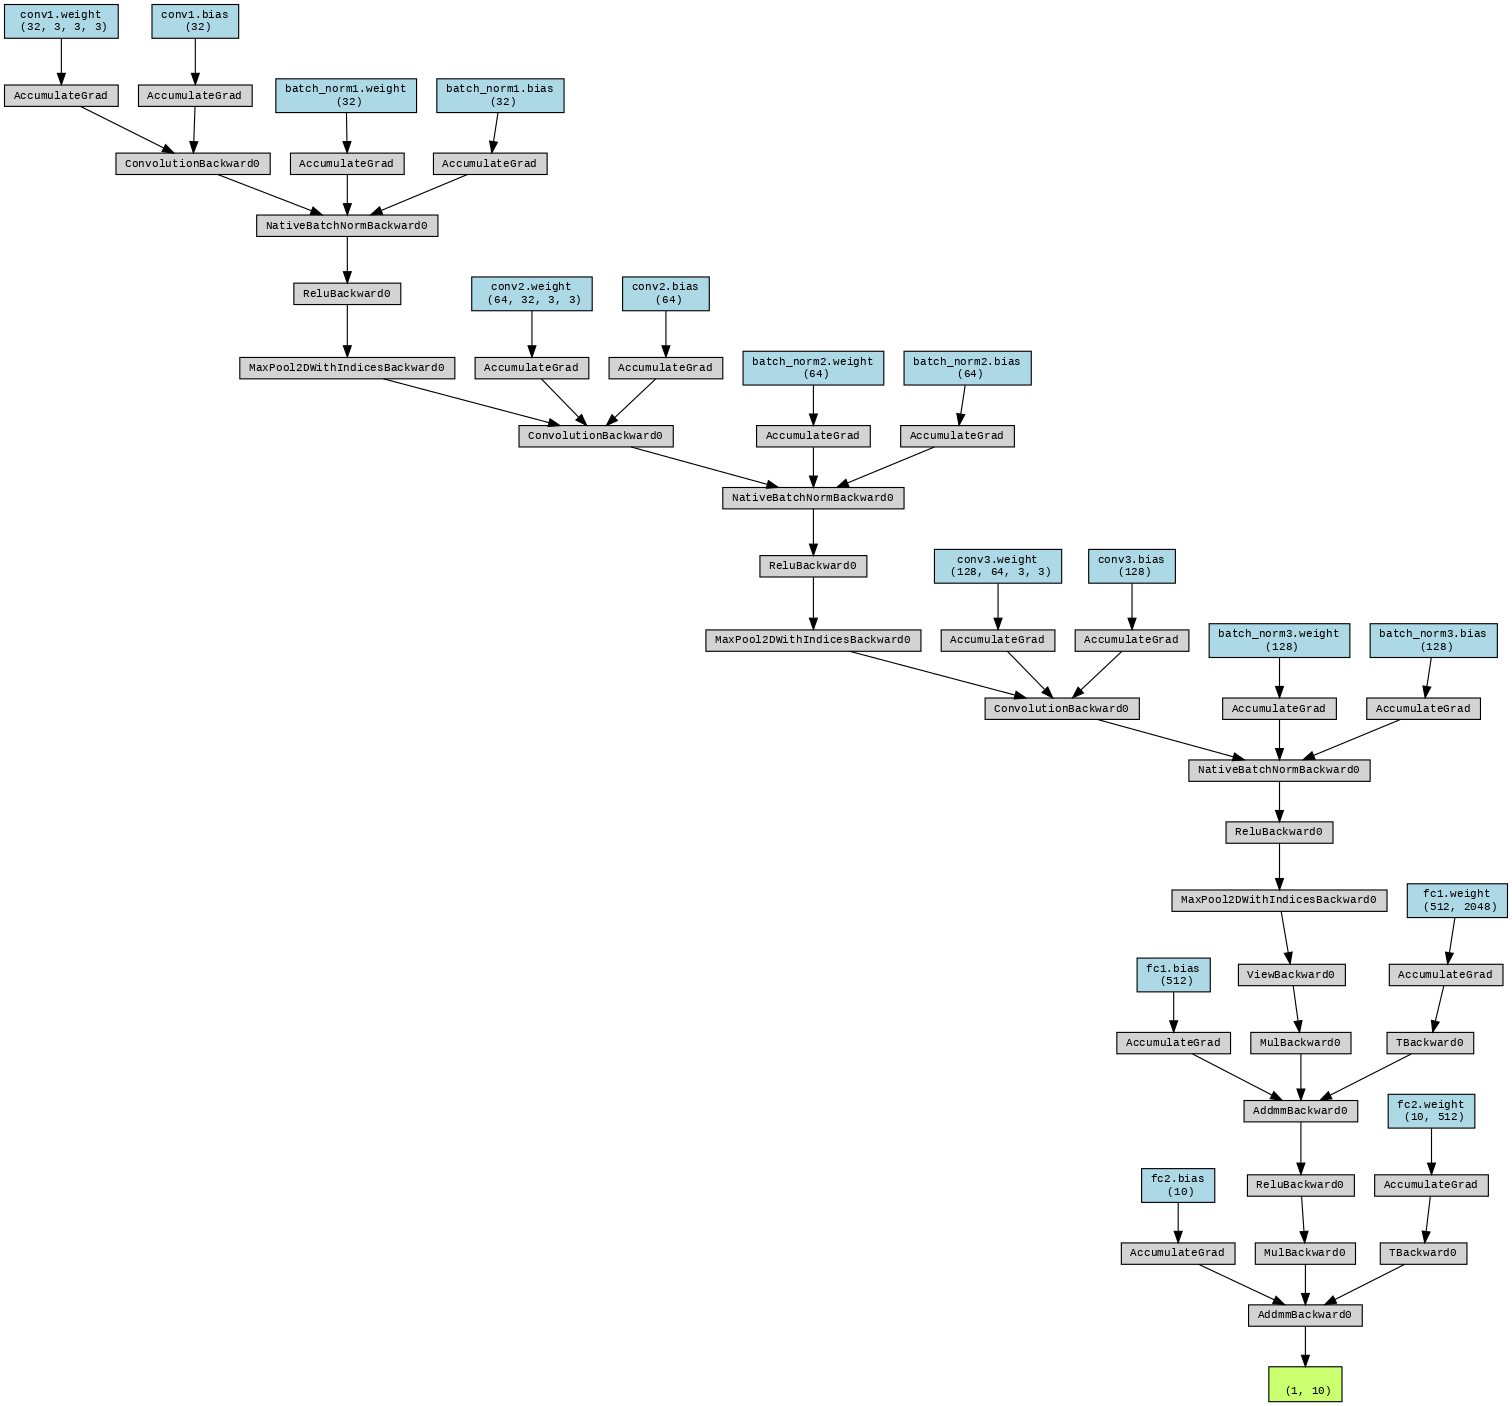

In [ ]:
# Visualise the structure of the model:

!apt-get install graphviz
!pip install torchviz

from torchviz import make_dot
from IPython.display import Image

# Create a random tensor that matches the size of your input.
x = torch.randn(1, 3, 32, 32)

# Run the tensor through your model to get the output
yhat = net(x)

# Generate a graph of the model
dot = make_dot(yhat, params=dict(list(net.named_parameters())))

# Save the dot object to a file
dot.format = 'png'
dot.render(filename='model_graph')

# Display the graph within the notebook
Image(filename='model_graph.png')

Epoch: 1, Mini-Batch:   200, Average Loss: 1.608
Epoch: 1, Mini-Batch:   400, Average Loss: 1.261
Validation - Epoch: 1, Loss: 0.991, Accuracy: 64.93%
Epoch: 2, Mini-Batch:   200, Average Loss: 1.013
Epoch: 2, Mini-Batch:   400, Average Loss: 0.968
Validation - Epoch: 2, Loss: 0.865, Accuracy: 69.48%
Epoch: 3, Mini-Batch:   200, Average Loss: 0.854
Epoch: 3, Mini-Batch:   400, Average Loss: 0.842
Validation - Epoch: 3, Loss: 0.819, Accuracy: 71.57%
Epoch: 4, Mini-Batch:   200, Average Loss: 0.769
Epoch: 4, Mini-Batch:   400, Average Loss: 0.764
Validation - Epoch: 4, Loss: 0.802, Accuracy: 72.14%
Epoch: 5, Mini-Batch:   200, Average Loss: 0.701
Epoch: 5, Mini-Batch:   400, Average Loss: 0.708
Validation - Epoch: 5, Loss: 0.709, Accuracy: 75.36%
Finished Training


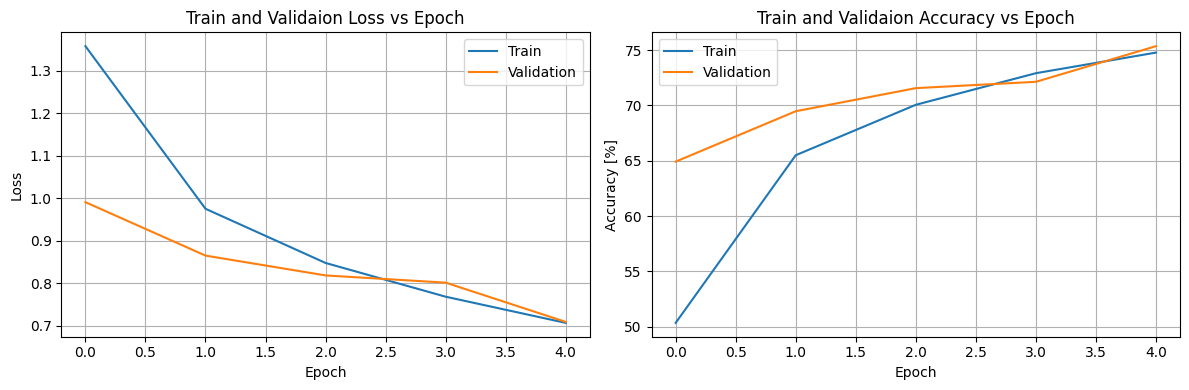

In [ ]:
#############################################################################
# TO DO:                                                                    #
# Define the training loop as seen in class and as demonstrated in the      #
# documentation. Note, if you are using GPU, make sure your code runs on    #
# CPU also. Code that cannot run will not be tested.                        #
#############################################################################

loss_values = []
accuracy_values = []

val_loss_values = []
val_accuracy_values = []

# Training loop for neural network
for epoch in range(5):  # Loop over the dataset multiple times (epochs)

    running_loss = 0.0  # Initialize running loss for each epoch
    in_batch_loss = 0.0

    # Initialize counters for correct predictions and total examples
    correct = 0
    total = 0

    # Set the model to training mode
    net.train()

    for i, data in enumerate(trainloader, 0):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Zero the gradients to avoid accumulation
        optimizer.zero_grad()

        # Forward pass: Compute predictions using the neural network
        outputs = net(inputs)  # The forward method of the net is automatically called by PyTorch

        # Compute the loss between predictions and actual labels
        loss = criterion(outputs, labels)

        # Backward pass: Compute gradients of the loss with respect to model parameters
        loss.backward()

        # Optimization step: Update model parameters based on computed gradients
        optimizer.step()

        print_interval = 200
        # Print statistics
        in_batch_loss += loss.item()
        if i % print_interval == (print_interval - 1):
            average_loss = in_batch_loss / print_interval
            print(f'Epoch: {epoch + 1}, Mini-Batch: {i + 1:5d}, Average Loss: {average_loss:.3f}')
            in_batch_loss = 0.0  # Reset running loss for the next set of mini-batches

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item()

    # Calculate average loss and accuracy for this epoch
    average_loss = running_loss / len(trainloader)
    epoch_accuracy = 100 * correct / total

    # Store average loss and accuracy
    loss_values.append(average_loss)
    accuracy_values.append(epoch_accuracy)

    # Validation at the end of the epoch
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # Set the model to evaluation mode
    net.eval()

    with torch.no_grad():
        for val_data in valloader:
            val_inputs, val_labels = val_data
            val_outputs = net(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()

            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    average_val_loss = val_loss / len(valloader)
    val_accuracy = 100 * val_correct / val_total
    val_loss_values.append(average_val_loss)
    val_accuracy_values.append(val_accuracy)

    print(f'Validation - Epoch: {epoch + 1}, Loss: {average_val_loss:.3f}, Accuracy: {val_accuracy:.2f}%')

print('Finished Training')

# Create a figure for plotting
plt.figure(figsize=(12, 4))

# Create a subplot for the loss
plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Train')
plt.plot(val_loss_values, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validaion Loss vs Epoch')
plt.legend()
plt.grid(True)

# Create a subplot for the accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy_values, label='Train')
plt.plot(val_accuracy_values, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.title('Train and Validaion Accuracy vs Epoch')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

Observing better validation results compared to training results can be attributed to several factors:

1. **Regularization**: During training, the model is in training mode where certain layers like dropout and batch normalization behave differently. These layers introduce some form of randomness which makes the model more robust but also more challenging to train, leading to higher training loss and lower accuracy.

2. **Model Evaluation**: When the model is switched to evaluation mode with `net.eval()`, it behaves more deterministically. Dropout is turned off and batch normalization uses running estimates instead of batch-specific ones. This can lead to lower validation loss and higher accuracy.

3. **Data Distribution**: If the validation set is somehow easier for the model to predict than the training set, this could lead to better performance on the validation set.

4. **Learning Rate**: If the learning rate is too high, the model might not settle on the optimal solution during training. However, during validation, when learning is turned off, the model might be closer to the optimal solution.

In this scenario, it's correct to select the model at the end of epoch 5 for further use or deployment. The reason is that this model has demonstrated the best performance on the validation set, as indicated by the lowest validation loss and the highest validation accuracy. This suggests that among all the models trained in different epochs, this model has the best ability to generalize to new, unseen data. It's important to note that the decision is based on the model's performance on the validation set, which serves as a stand-in for the model's ability to handle new data it hasn't seen during training. Therefore, in situations like this, it's a common and recommended practice to choose the model with the best validation performance.

## Model evaluation

Calculate the model accuracy and print a confusion matrix where in y axis represents the real category and the x axis represents the predicted category. **(10 points)**

In [ ]:
confusion_matrix = np.zeros([10,10], int)
model_accuracy = 0
#############################################################################
# TO DO:                                                                    #
# Define the evaluation loop as seen in class and as demonstrated in the    #
# documentation and use the confusion matrix to evaluate your model.        #
#############################################################################

# Initialize counters for correct predictions and total examples
correct = 0
total = 0

# Disable gradient computation since we're not training
with torch.no_grad():
    # Iterate through the test data loader
    for data in testloader:
        # Retrieve images and corresponding labels from the current batch
        images, labels = data

        # Calculate model predictions by passing images through the network
        outputs = net(images)

        # Select the class with the highest predicted probability as the model's prediction
        _, predicted = torch.max(outputs.data, 1)  # Along dimension 1 (columns), get the index of the maximum value

        # Update the total number of examples processed
        total += labels.size(0)  # labels.size(0) gives the batch size

        # Count the number of correct predictions
        correct += (predicted == labels).sum().item()  # Convert the sum to a Python number using .item()

        # Update the confusion matrix
        for i in range(len(labels)):
          confusion_matrix[labels[i], predicted[i]] += 1

# Calculate the accuracy of the network on the entire test dataset
model_accuracy = 100 * correct // total  # Calculate percentage accuracy

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
print('Model accuracy on {0} test images: {1:.2f}%'.format(len(testset), model_accuracy))

Model accuracy on 10000 test images: 75.00%


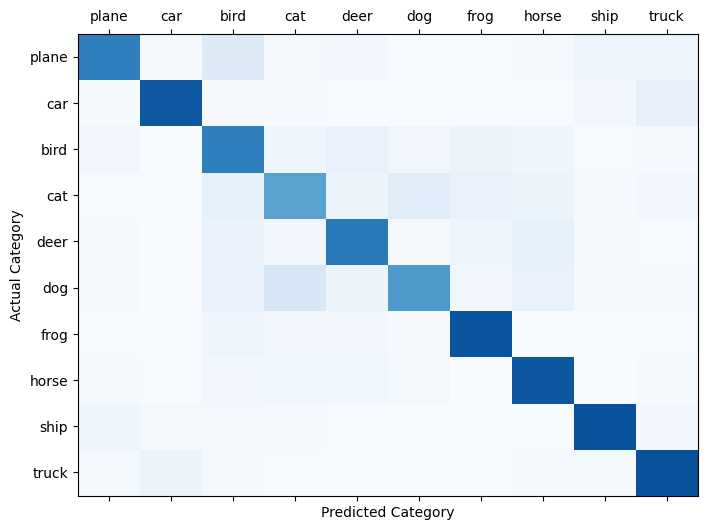

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

##**Question:**
Describe your experiments.
What parameters have you experimented with? What works and what doesn't? Why?   **(5 Points)**

**Your answer:**

I conducted a series of experiments to optimize the performance of the neural network. Initially, I followed a standard architecture with convolutional layers, ReLU activation, and pooling. However, the model's depth was insufficient, yielding an accuracy of approximately 50%.

To address this, **I implemented batch normalization, dropout, and increased the network depth.** This modification led to a notable improvement, raising the accuracy to around 70%. Subsequently, **I switched to the Adam optimizer, resulting in an additional 3% accuracy boost, reaching a total of 73%.**

Throughout the experimentation, **I systematically adjusted parameters such as the number of convolutional layers, kernel sizes, channel quantities, and epochs. Notably, increasing the number of epochs consistently improved accuracy.** All modifications were informed by principles outlined in lectures, and each adjustment contributed positively to the model's performance. **No changes were identified as ineffective, as adherence to lecture guidelines consistently led to improvements.**




##**Question:**
What can you learn from the confusion matrix? Why do you need additional evaluation methods other than accuracy? **(5 Points)**

**Your answer:**

A confusion matrix provides a detailed breakdown of my model's predictions, categorizing them into **True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)**. Analyzing these categories provides insights into recall, accuracy, precision, and overall effectiveness in class distinction.

Upon examining my confusion matrix, I observed that the majority of predictions align with the diagonal, indicating a high rate of correct predictions (**TP and TN**). This positive outcome suggests that my model performs well in distinguishing between classes.

However, I also noted intensity in off-diagonal elements, indicating instances of incorrect predictions (**FP and FN**), such as predicting a cat as a dog. These misclassifications highlight areas where my model may be struggling and could be enhanced.

While accuracy serves as a useful metric, its interpretation can be misleading, especially in imbalanced data scenarios where a model might achieve high accuracy by predicting the majority class. To address this limitation, metrics derived from the confusion matrix, such as **precision, recall, and the F1 score**, offer a more nuanced understanding of my model's performance. Therefore, while accuracy serves as a starting point, additional evaluation methods are essential for a comprehensive assessment.

Analyzing both diagonal and off-diagonal elements in my confusion matrix allows me to gain a more complete understanding of my model's performance and identify areas for improvement. This is why I recognize the importance of employing additional evaluation methods beyond accuracy to provide a detailed and comprehensive view of my model's performance.


# Localization as Regression (60 points)

In the next part, we will use a well known architecture called ResNet18 that was trained on ImageNet, a dataset far more rich than CIFAR10. ImageNet has 1,000 classes and 1,000,000 images. In this part, we will use the features extracted from ResNet18 to localize and classify images of cats and dogs.

Using a pretrained network as a building block for a more complicated task is at the heart of neural networks today. By leveraging the features ResNet18 extracts, we can train a model that can correctly classify and localize cats and dogs using very few images.

In [ ]:
import torchvision.transforms as transforms
from data.dataloader import *
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import collections
import time
import copy
import sys
import os

To load ResNet18 with the pretrained weights, use the following line. You are welcome to try different architectures, however they might require different input sizes or normalization.

The first time you run this cell the weights will be downloaded.

In [ ]:
resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

ResNet takes as input images of size (224,224). We will use PyTorch Transforms to change the size of the images. When ResNet18 was trained on ImageNet, the images were normalized using the mean and standard deviation of the images. In order to properly use the weights, we will use the same normalization.

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalizing according to imagenet
    ]),
    'val': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
#root_dir = "drive/MyDrive/Semester 1/למידה עמוקה/תרגיל בית 3/data/animals/"
root_dir = "data/animals/"
datasets = {x: VOCDetection(root_dir, image_set=x, transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
classes = datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)

{'train': 636, 'val': 158}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Get a batch of training data
sample = next(iter(dataloaders['train']))

<Figure size 640x480 with 0 Axes>

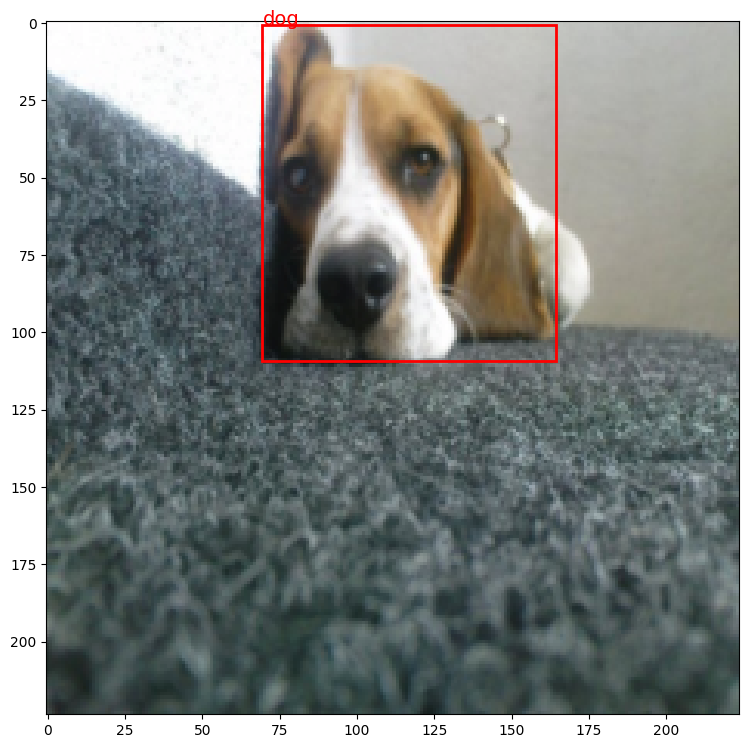

In [ ]:
def imshow(img, label, bbox):
    image = np.copy(img[0])
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    label = label[0]
    bbox = bbox[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    x1, y1, x2, y2 = bbox.numpy().reshape(-1) * 224
    box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2,
                             edgecolor='r', facecolor='none');
    ax.add_patch(bbox);
    ax.annotate(classes[label], (x1, y1), color='r', fontsize=14);

imshow(sample['image'],sample['label'],sample['bbox'])

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Load the pretrained ResNet-18 network and replace the top fully connected #
        # layer, so we could use the features of the network and not the only       #
        # the classification layer which carries significantly less information.    #
        # Afterwards, create a new sequential model with the remaining layers of    #
        # the pretrained network. Next, define two additional models that take as   #
        # input the extracted features and output the class scores and bounding box #
        # coordinates.                                                              #
        # Clarrification - You required to build 2 models - one for classification  #
        # and one for detection.                                                    #
        # The classification model is of shape: resent_features -> FC/FCs -> scores.#
        # The detection model is of shape: resent_features -> FC/FCs -> bbox.       #
        # You may train/leave frozen the resent_features backbone, try              #
        # experimenting with it.                                                    #
        # This function has no return value.                                        #
        #############################################################################

        # Initialize ResNet18 model
        self.resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

        # Extract layers for feature extraction
        layers = list(self.resnet18.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])  # First 6 layers
        self.features2 = nn.Sequential(*layers[6:])  # Remaining layers

        # Classifier for classification task
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(512),  # Batch normalization
            nn.Linear(512, 2)  # Fully connected layer for classification
        )

        # Bounding box regressor for object detection task
        self.bb = nn.Sequential(
            nn.BatchNorm1d(512),  # Batch normalization
            nn.Linear(512, 4)  # Fully connected layer for bounding box regression
        )

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # predefined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training.                                                  #
        # This function returns a class predication and a bounding box coordinates. #
        #############################################################################

        # Forward pass through ResNet18 feature extraction layers
        x = self.features1(images)
        x = self.features2(x)

        # ReLU activation
        x = F.relu(x)

        # Adaptive average pooling
        x = nn.AdaptiveAvgPool2d((1,1))(x)  # Perform adaptive average pooling to reduce spatial dimensions to 1x1

        # Flatten features for classification
        x = x.view(x.shape[0], -1)

        # Classification output and bounding box regression output
        return self.classifier(x), self.bb(x)

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

## Guidelines

1. Complete the `train_model` function in the cell below. This function takes as input the model and additional hyper-parameters, and outputs the best model found on the validation set.
2. To babysit the learning process, **you must track the classification accuracy, IoU score and loss on the training and validation datasets and visualize them** (using matplotlib or similar). I have included an implementation of the IoU metric in the file `data\dataloader.py`.
3. Do not perform a massive grid search. Use papers, blogs, MOOCs and online guides to research best hyper-parameters for your model.
4. You are encouraged to try Google Colab. If you have an CUDA capable GPU at home - you are welcome to use it.
5. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
6. Training large neural networks may take a while. Make sure your code runs reasonably fast (~15 minutes on CPU and ~5 minutes on GPU).
7. Try to reach at least 90% classification accuracy and a IOU score of at least 0.60 on the validation set.
8. **In order to get full marks for this section explain the results and include visualizations.**.
9. You are given a general skeleton for the training function. Feel free to use any different structure.

In [ ]:
def bb_intersection_over_union_efficient(boxA, boxB):
    # The function takes two arguments, boxA and boxB, which are 2D tensors where each row represents a bounding box in the format [x1, y1, x2, y2].

    # The (x, y)-coordinates of the intersection rectangle are determined.
    # torch.max and torch.min are used to find the coordinates of the intersection of boxA and boxB.
    xA = torch.max(boxA[:, 0], boxB[:, 0]) # Maximum of the x1 coordinates
    yA = torch.max(boxA[:, 1], boxB[:, 1]) # Maximum of the y1 coordinates
    xB = torch.min(boxA[:, 2], boxB[:, 2]) # Minimum of the x2 coordinates
    yB = torch.min(boxA[:, 3], boxB[:, 3]) # Minimum of the y2 coordinates

    # The area of the intersection rectangle is computed.
    # torch.clamp is used to ensure that the width and height of the intersection are not less than 0.
    interArea = torch.clamp(xB - xA + 1, min=0) * torch.clamp(yB - yA + 1, min=0)

    # The area of both the prediction and ground-truth rectangles are computed.
    boxAArea = (boxA[:, 2] - boxA[:, 0] + 1) * (boxA[:, 3] - boxA[:, 1] + 1)
    boxBArea = (boxB[:, 2] - boxB[:, 0] + 1) * (boxB[:, 3] - boxB[:, 1] + 1)

    # The Intersection over Union (IoU) is computed by taking the area of the intersection
    # and dividing it by the sum of the areas of boxA and boxB, minus the intersection area.
    iou = interArea / (boxAArea + boxBArea - interArea)

    # Sum the IoU values and convert to a scalar
    iou = iou.sum().item()

    # The IoU value is returned. This will be a tensor of the same length as the input tensors,
    # where each element is the IoU of the corresponding pair of bounding boxes.
    return iou

def train_model(model, criterion_cls, criterion_bbox, optimizer, scheduler=None, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict()) # this is how a model is copied
    best_acc = 0.0

    print("Current device:", device)

    logger_dict = {
    'train_loss': [],
    'train_acc': [],
    'train_iou': [],
    'val_loss': [],
    'val_acc': [],
    'val_iou': []
    }

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0   # total loss of the network at each epoch
            running_corrects = 0 # number of correct predictions
            iou = 0.0            # IoU score

            # Iterate over data.
            for sample in dataloaders[phase]:
                #############################################################################
                # TO DO:                                                                    #
                # Extract the data from the dataloader, calculate the predictions of your   #
                # network and calculate the loss of the classification and bounding box     #
                # prediction. When in training mode, back-prop and update the weights.      #
                # At each epoch, calculate the test and train accuracy and IoU.             #
                # This function returns the best model in terms of accuracy.                #
                #############################################################################

                # Extract data
                inputs = sample['image']
                labels = sample['label']
                bboxs = sample['bbox']

                # Move data to the appropriate device (CPU or GPU)
                inputs = inputs.to(device)
                labels = labels.to(device)
                bboxs = bboxs.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    # Forward pass: Compute predicted outputs by passing inputs through the model.
                    outputs_cls, outputs_bbox = model(inputs)

                    # Classification processing
                    _, preds = torch.max(outputs_cls, 1)  # Get the predicted class labels
                    loss_cls = criterion_cls(outputs_cls, labels)  # Compute the classification loss

                    # Bounding box processing
                    # Multiply the bounding box loss by 10 to increase its impact relative to the classification loss.
                    # This compensates for the typically lower classification loss expected due to using a pretrained ResNet backbone.
                    loss_bbox = (criterion_bbox(outputs_bbox, bboxs)) * 10

                    # Compute total loss
                    loss = loss_cls + loss_bbox

                    # Backward pass + optimize only during the training phase
                    if phase == 'train':
                        loss.backward()  # Backpropagation
                        optimizer.step()  # Update model parameters

                # Compute statistics for monitoring training progress
                # Accumulate the loss over the entire dataset
                running_loss += loss.item() * inputs.size(0)

                # Compute the number of correctly predicted samples
                running_corrects += (torch.sum(preds == labels.data)).item()

                # Compute Intersection over Union (IoU)
                iou += bb_intersection_over_union_efficient(outputs_bbox, bboxs)

                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = float(running_corrects) / dataset_sizes[phase]
            #iou = iou.item() / dataset_sizes[phase]
            iou = iou / dataset_sizes[phase]

            print('{} Loss: {:.4f}  |  Acc: {:.4f}  |  IOU: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, iou))

            # Logging
            # If in the training phase, append epoch loss, accuracy, and IoU to the training logger dictionary
            if phase == 'train':
              logger_dict['train_loss'].append(epoch_loss)
              logger_dict['train_acc'].append(epoch_acc)
              logger_dict['train_iou'].append(iou)
            # If in the validation phase, append epoch loss, accuracy, and IoU to the validation logger dictionary
            else:
              logger_dict['val_loss'].append(epoch_loss)
              logger_dict['val_acc'].append(epoch_acc)
              logger_dict['val_iou'].append(iou)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch + 1
                print("Best epoch:", best_epoch)


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    logger_dict = {key: value[:best_epoch] for key, value in logger_dict.items()}

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, logger_dict

**Explanation of Above Code**

**Bounding Box Intersection over Union Function**

This function calculates how much two bounding boxes overlap, which helps evaluate object detection models.

**Training Model Function**

This function trains a custom object detection model in two main phases: training and validation.

- **Initialization**: Set up variables needed for tracking progress.
- **Epoch and Phase Loop**: Go through each training and validation cycle.
- **Data Iteration**: Process each batch of data.
- **Forward Pass**: Use the model to predict classifications and bounding boxes.
- **Loss Computation**: Calculate losses for classification and bounding boxes. The bounding box loss is multiplied by 10 to give it more importance, compensating for the usually lower classification loss.
- **Backpropagation and Optimization**: Update the model's parameters to minimize the loss.
- **Metrics Calculation**: Keep track of loss, accuracy, and overlap between predicted and actual bounding boxes.
- **Logging**: Print and log important metrics for monitoring progress.
- **Best Model Update**: Keep track of the best model based on validation accuracy.
- **Training Completion**: Print out how long training took and the best validation accuracy achieved.

Choose your optimizer and the loss functions for the classification and bounding box regression.

In [ ]:
import torch.optim as optim

cnn = CNN(2)
cnn = cnn.to(device)

criterion_cls = None
criterion_bbox = None
optimizer = None
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################

# Cross Entropy Loss for classification
criterion_cls = nn.CrossEntropyLoss()

# L1 Loss for bounding box regression
criterion_bbox = nn.L1Loss()

# Optimizer
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


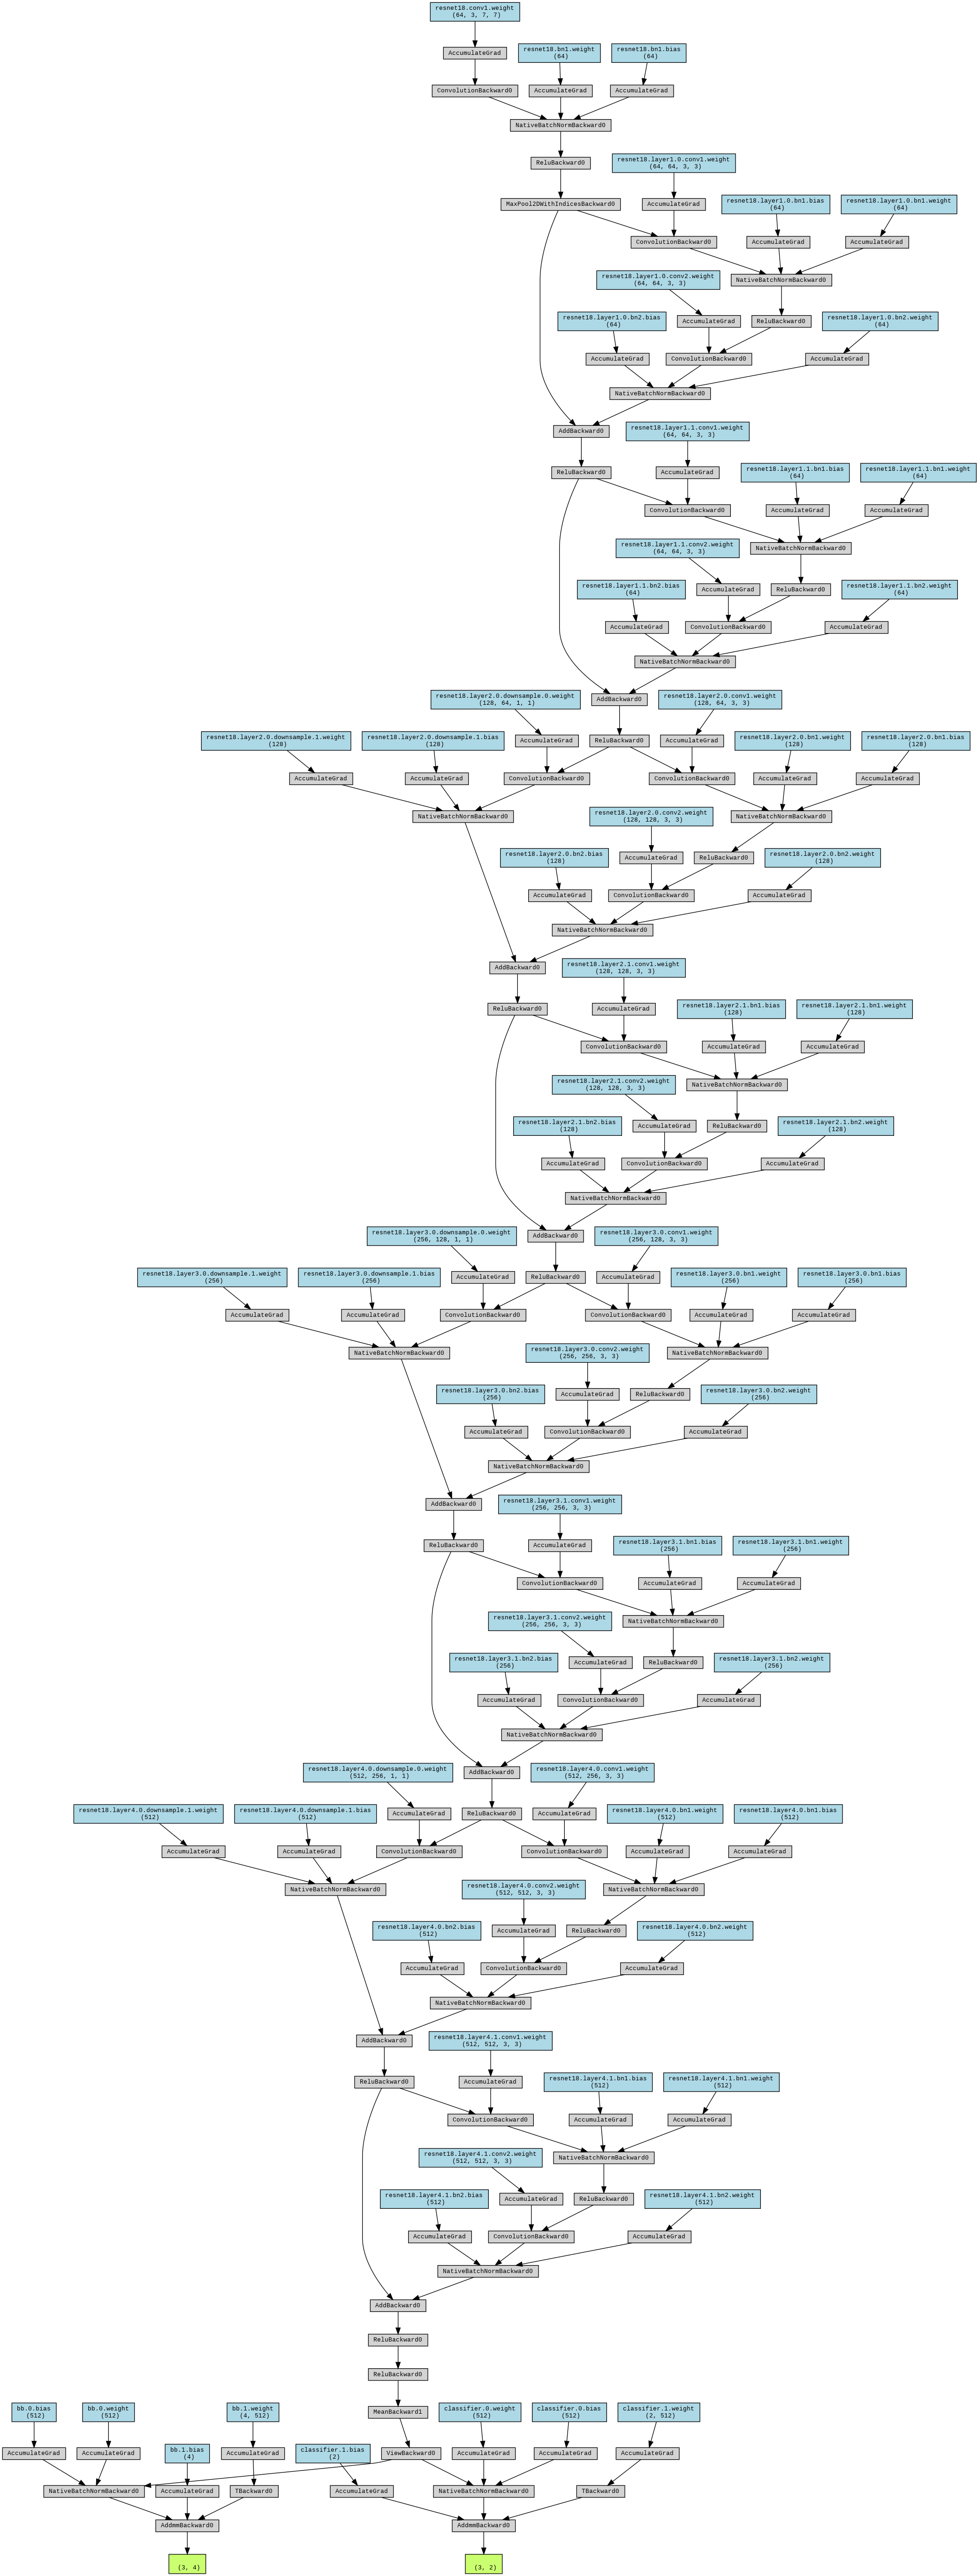

In [ ]:
# Visualise the structure of the model:

!apt-get install graphviz
!pip install torchviz

from torchviz import make_dot
from IPython.display import Image

# Create a random tensor that matches the size of your input.
x = torch.randn(3, 3, 224, 224)

# Run the tensor through your model to get the output
yhat = cnn(x)

# Generate a graph of the model
dot = make_dot(yhat, params=dict(list(cnn.named_parameters())))

# Save the dot object to a file
dot.format = 'png'
dot.render(filename='model_graph')

# Display the graph within the notebook
Image(filename='model_graph.png')

In [ ]:
best_model, logger_dict = train_model(cnn, criterion_cls, criterion_bbox, optimizer, num_epochs=20)

Current device: cuda:0
Epoch 1/20
----------
train Loss: 7.0433  |  Acc: 0.8821  |  IOU: 0.1633
val Loss: 88.8503  |  Acc: 0.7342  |  IOU: 0.0097
Best epoch: 1
Epoch 2/20
----------
train Loss: 3.6035  |  Acc: 0.8082  |  IOU: 0.3971
val Loss: 6.5274  |  Acc: 0.8418  |  IOU: 0.2778
Best epoch: 2
Epoch 3/20
----------
train Loss: 1.9482  |  Acc: 0.9072  |  IOU: 0.6244
val Loss: 1.5029  |  Acc: 0.8671  |  IOU: 0.7252
Best epoch: 3
Epoch 4/20
----------
train Loss: 1.1170  |  Acc: 0.9623  |  IOU: 0.7634
val Loss: 1.2306  |  Acc: 0.9051  |  IOU: 0.7633
Best epoch: 4
Epoch 5/20
----------
train Loss: 1.0499  |  Acc: 0.9717  |  IOU: 0.7698
val Loss: 1.2024  |  Acc: 0.9177  |  IOU: 0.7564
Best epoch: 5
Epoch 6/20
----------
train Loss: 0.9987  |  Acc: 0.9796  |  IOU: 0.7779
val Loss: 0.9623  |  Acc: 0.9241  |  IOU: 0.8022
Best epoch: 6
Epoch 7/20
----------
train Loss: 0.8920  |  Acc: 0.9748  |  IOU: 0.8032
val Loss: 1.2052  |  Acc: 0.8861  |  IOU: 0.8065
Epoch 8/20
----------
train Loss: 0.79

Once you are pleased with your results, see how your model can predict and localize cats and dogs!

<Figure size 1200x800 with 0 Axes>

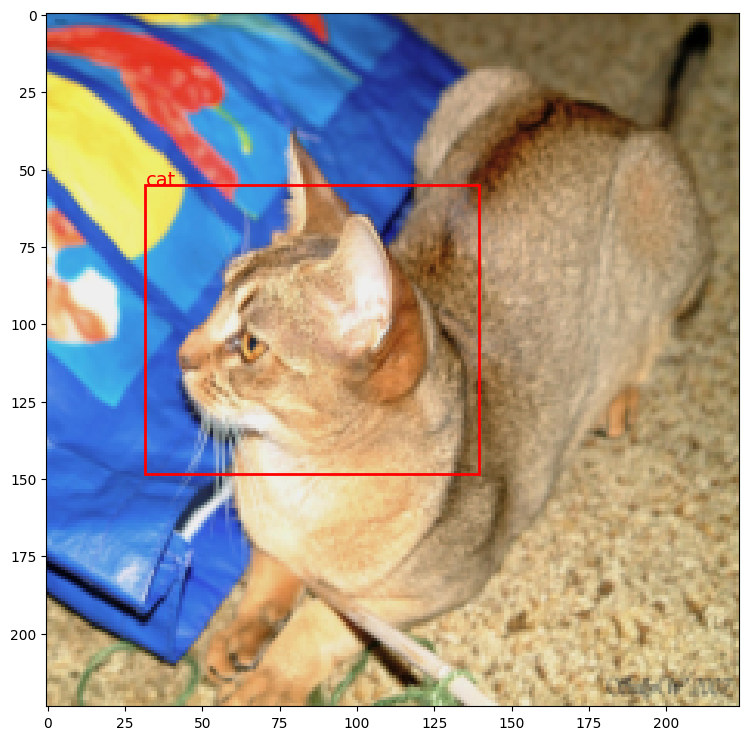

In [ ]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)
    _, label_pred = torch.max(label_pred, 1)
imshow(sample['image'], label_pred.cpu(), bbox_pred.cpu())

Your visualizations here (IoU / Accuracy / Loss on training and validation datasets as a function of the epoch). Only visualize the results of your best model.

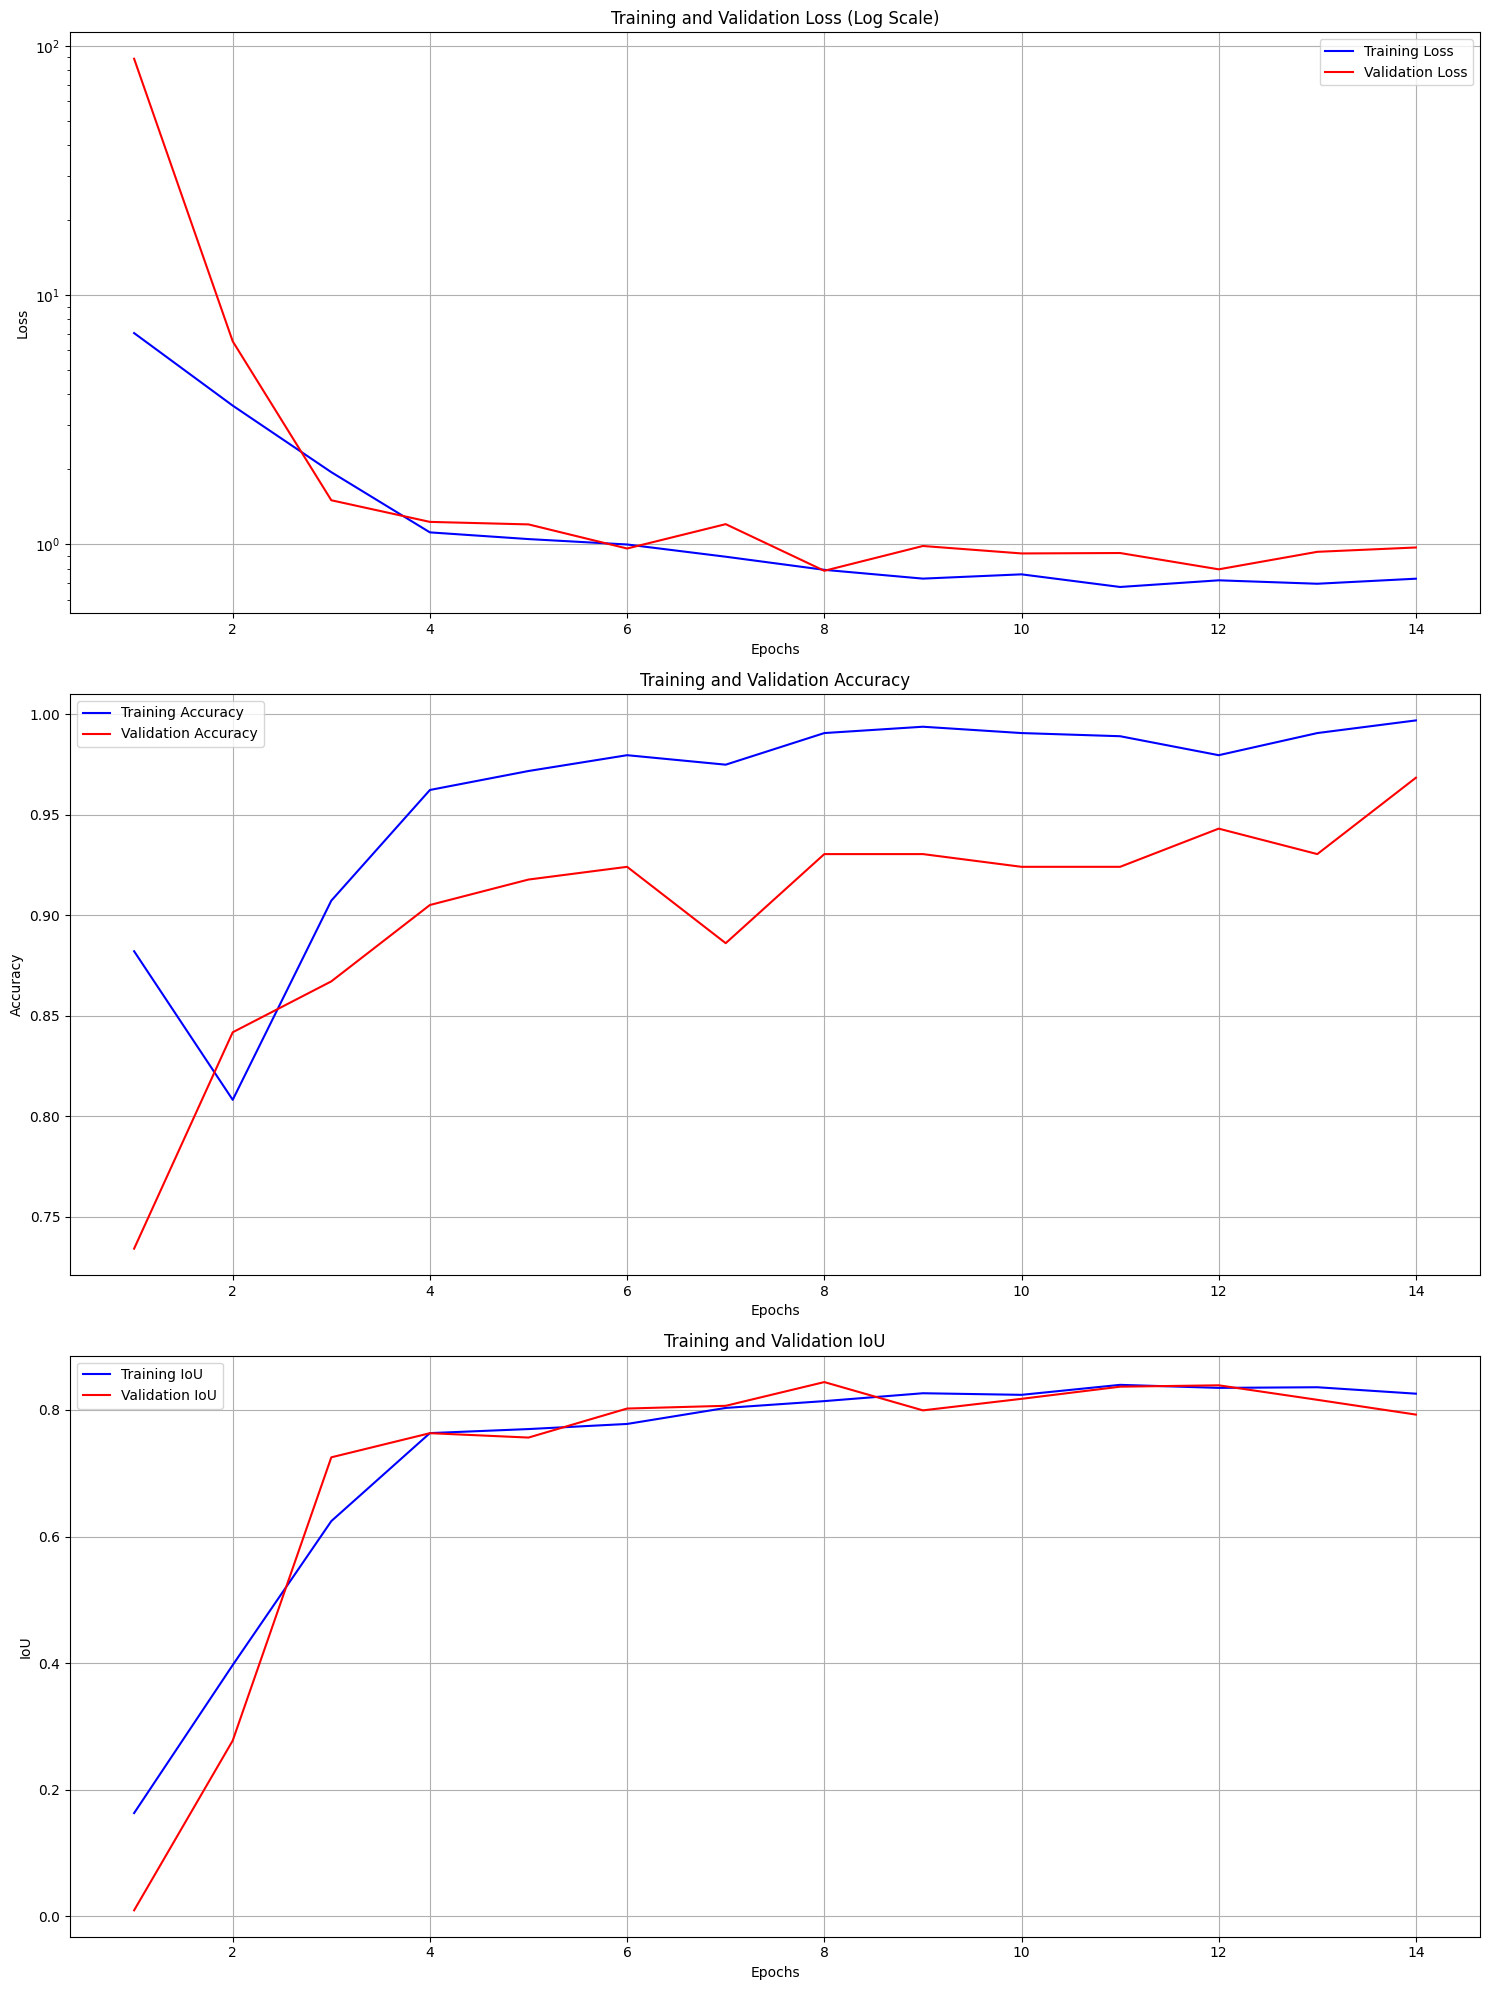

In [ ]:
# Data
epochs = range(1, len(logger_dict['train_loss']) + 1)
train_loss = logger_dict['train_loss']
train_acc = logger_dict['train_acc']
train_iou = logger_dict['train_iou']
val_loss = logger_dict['val_loss']
val_acc = logger_dict['val_acc']
val_iou = logger_dict['val_iou']

# Plotting
plt.figure(figsize=(15, 20))

# Plotting training and validation loss with logarithmic scale
plt.subplot(3, 1, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.yscale('log')  # Apply logarithmic scale to y-axis
plt.title('Training and Validation Loss (Log Scale)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting training and validation accuracy
plt.subplot(3, 1, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plotting training and validation IoU
plt.subplot(3, 1, 3)
plt.plot(epochs, train_iou, 'b-', label='Training IoU')
plt.plot(epochs, val_iou, 'r-', label='Validation IoU')
plt.title('Training and Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plots
plt.show()

